# 14.10 预训练BERT
- **目录**
  - 14.10.1 预训练BERT
  - 14.10.2 用BERT表示文本

- 利用14.8节中实现的BERT模型和14.9节中从WikiText-2数据集生成的预训练样本，我们将在本节中在WikiText-2数据集上对BERT进行预训练。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

- 首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。
  - 批量大小是512，BERT输入序列的最大长度是64。
  - 注意，在原始BERT模型中，输入序列最大长度是512。


In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

----------
- **说明：**
  - 如load_data_wiki函数发生如下错误或在windows平台下运行十分缓慢，则可以修改torch.py代码
  <img src='../img/14_10_1.png'>

  - 修改源代码：F:\Users\hp\AppData\Local\Programs\Python\Python310\Lib\site-packages\d2l\torch.py
  <img src='../img/14_10_2.png'>
  <img src='../img/14_10_3.png'>
---------

## 14.10.1 预训练BERT

- 原始BERT有两个不同模型尺寸的版本。
  - 基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。
  - 大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。
  - 值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。
- 为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。


In [3]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

- 在定义训练代码实现之前，先定义了一个辅助函数`_get_batch_loss_bert`。
  - 给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。
  - 请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。


In [4]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

- _get_batch_loss_bert详细注释

In [4]:
len(vocab)

20256

In [ ]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    '''
    前向传播，获取MLM和NSP任务的预测输出。
    mlm_Y_hat的形状是：(批量大小，预测长度，词表大小)，具体值为：(512, 10, 20256)，
                       预测长度10 = round(64*0.15)
    nsp_Y_hat的形状是：(批量大小, 二分类输出特征数)，具体值为：(512, 2)
    
    '''
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    '''
    计算遮蔽语言模型损失.
    mlm_Y_hat变形后为：(5120, 20256)
    mlm_Y变形后为：(5120, )
    loss函数调用后的结果为标量，即平均损失。
    后续计算有争议！个人观点，仅供参考。
    mlm_weights_X变形：(5120, 1)，本质是和每条数据loss值(每个条数据有10个损失值)乘以权重，
                      排除填充的损失参与计算，即设为0。
    然后对mlm_l求和再除以mlm_weights_X的和，得到mlm_l的平均损失。
    个人感觉，上述两个操作属多余，不会改变mlm_l经过loss直接计算出来的值。
    注意： mlm_weights_X.sum() 即有效预测词元的总个数；+ 1e-8是防止分母为0，数值计算的稳定性。
    '''
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    '''
    计算下一句子预测任务的损失。
    nsp_Y_hat：(512, 2)
    nsp_y：(512)
    计算结果是标量。
    然后求两个损失之和。
    '''
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

- 通过调用上述两个辅助函数，下面的train_bert函数定义了在WikiText-2（train_iter）数据集上预训练BERT（net）的过程。
- 训练BERT可能需要很长时间。
- 以下函数的输入num_steps指定了训练的迭代步数，而不是像train_ch13函数那样指定训练的轮数（参见 13.1节）。

In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            # 屏蔽无效预测位置，比如填充词元<pad>
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

- 在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。


MLM loss 5.494, NSP loss 0.764
350.6 sentence pairs/sec on [device(type='cuda', index=0)]


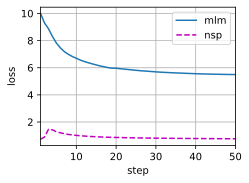

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## 14.10.2 用BERT表示文本

- 在预训练BERT之后，可以用它来表示**单个文本**、**文本对**或其中的**任何词元**。
- 下面的函数返回`tokens_a`和`tokens_b`中所有词元的BERT（`net`）表示。


In [7]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    # 后两个返回值是MLM和NSP预测结果，忽略
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

- 考虑“a crane is flying”这句话。
- 回想一下 14.8.4节中讨论的BERT的输入表示。
  - 插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，BERT输入序列的长度为6。
  - 因为零是“&lt;cls&gt;”词元，`encoded_text[:, 0, :]`是整个输入语句的BERT表示。
- 为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。


In [ ]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

- 现在考虑一个句子“a crane driver came”和“he just left”。
- 类似地，`encoded_pair[:, 0, :]`是来自预训练BERT的整个句子对的编码结果。
- 注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。


In [10]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.7987, -1.2277, -0.6077], device='cuda:0', grad_fn=<SliceBackward0>))

- 在 第15章中，我们将为下游自然语言处理应用微调预训练的BERT模型。

## 小结

* 原始的BERT有两个版本，其中基本模型有1.1亿个参数，大模型有3.4亿个参数。
* 在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。
* 在实验中，同一个词元在不同的上下文中具有不同的BERT表示。这支持BERT表示是上下文敏感的。